In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import random
from itertools import chain

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install nltk
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Data Augmentation

In [ ]:
def swap_synonyms(text, max_replacements=5):
    '''Troca algumas palavras aleatórias por seus sinônimos.'''

    words = word_tokenize(text, language='portuguese')
    portuguese_stopwords = set(stopwords.words('portuguese'))

    to_swap = [
        idx for idx, word in enumerate(words)
        if word.lower() not in portuguese_stopwords and word.isalpha()
    ]

    random.shuffle(to_swap)
    num_replacements = min(max_replacements, len(to_swap))

    for i in range(num_replacements):
        idx = to_swap[i]
        original_word = words[idx]
        synonyms = get_synonyms(original_word)

        if synonyms:
            words[idx] = random.choice(synonyms)

    return ' '.join(words)

def get_synonyms(word):
    '''Retorna o sinônimo da palavra'''
    synsets = wordnet.synsets(word, lang='por')
    synonyms = set(chain.from_iterable(syn.lemma_names('por') for syn in synsets))
    synonyms.discard(word.lower())
    return list(synonyms)

def remove_random_stopwords(text, max_removals=5):
    '''Remove stopwords aleatórias.'''
    words = word_tokenize(text, language='portuguese')
    portuguese_stopwords = set(stopwords.words('portuguese'))

    stopword_indices = [idx for idx, word in enumerate(words) if word.lower() in portuguese_stopwords]

    if not stopword_indices:
        return text

    num_removals = min(max_removals, len(stopword_indices))
    indices_to_remove = random.sample(stopword_indices, num_removals)

    filtered_words = [word for idx, word in enumerate(words) if idx not in indices_to_remove]

    return ' '.join(filtered_words)

In [ ]:
def augment_data(df):
    '''
    Aplica aumentação de dados.
    Operações:
        - Remove o assunto do email
        - Troca de sinônimos aleatoriamente.
        - Remove stopwords aleatórias.
    '''
    augmented_texts = []
    augmented_labels = []

    for _, row in df.iterrows():
        # Deixa alguns emails sem assunto e outros com.
        text_with_subject = f"{row['Assunto']}\n{row['Corpo']}"
        text_without_subject = row['Corpo']

        augmented_texts.extend([text_with_subject, text_without_subject])
        augmented_labels.extend([row['Label'], row['Label']])

        # Troca os sinônimos
        text_synonym = swap_synonyms(text_with_subject, max_replacements=2)
        augmented_texts.append(text_synonym)
        augmented_labels.append(row['Label'])

        # Remove stopwords aleatórias
        text_stopword = remove_random_stopwords(text_with_subject, max_removals=5)
        augmented_texts.append(text_stopword)
        augmented_labels.append(row['Label'])

    augmented_df = pd.DataFrame({
        'Assunto': [text.split('\n')[0] if '\n' in text else '' for text in augmented_texts],
        'Corpo': [text.split('\n')[1] if '\n' in text else text for text in augmented_texts],
        'Label': augmented_labels
    })

    # Une as alterações
    combined_df = pd.concat([df, augmented_df], ignore_index=True)
    return combined_df

df = pd.read_csv('emails_dataset.csv')
df = augment_data(df)

print(df.shape)

(5500, 5)


In [ ]:
class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.texts = df.apply(lambda x: f"{x['Assunto']}\n{x['Corpo']}", axis=1).values
        self.labels = df['Label'].apply(lambda x: 1 if x == "Produtivo" else 0).values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def _preprocess_text(self, text):
        text = re.sub(r'[*#_\->|]', '', text)
        text = ' '.join(text.split())
        return text

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        text = self._preprocess_text(text)

        label = self.labels[idx]
        tokens = self.tokenizer(
            text,
            add_special_tokens=True,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
        )

        return {
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.int64)
        }

In [ ]:
batch_size = 16

tokenizer = AutoTokenizer.from_pretrained('adalbertojunior/distilbert-portuguese-cased', do_lower_case=False)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['Label']
)

train_dataset = EmailDataset(train_df, tokenizer)
val_dataset = EmailDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Treinamento

In [ ]:
def train_model(model, train_loader, val_loader, epochs=3, learning_rate=2e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Validação
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                val_loss += outputs.loss.item()

                predictions = torch.argmax(outputs.logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

        print(f'Epoch {epoch + 1}:')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        print(f'Validation Accuracy: {100 * correct/total:.2f}%\n')

model = AutoModelForSequenceClassification.from_pretrained('adalbertojunior/distilbert-portuguese-cased',num_labels=2)

train_model(model, train_loader, val_loader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at adalbertojunior/distilbert-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:
Training Loss: 0.1187
Validation Loss: 0.0556
Validation Accuracy: 98.27%

Epoch 2:
Training Loss: 0.0338
Validation Loss: 0.0603
Validation Accuracy: 97.82%

Epoch 3:
Training Loss: 0.0329
Validation Loss: 0.0503
Validation Accuracy: 97.82%



# Validação

Final Validation Loss: 0.0503
Final Validation Accuracy: 97.82%

Classification Report:
              precision    recall  f1-score   support

 Improdutivo       0.99      0.97      0.98       550
   Produtivo       0.97      0.99      0.98       550

    accuracy                           0.98      1100
   macro avg       0.98      0.98      0.98      1100
weighted avg       0.98      0.98      0.98      1100



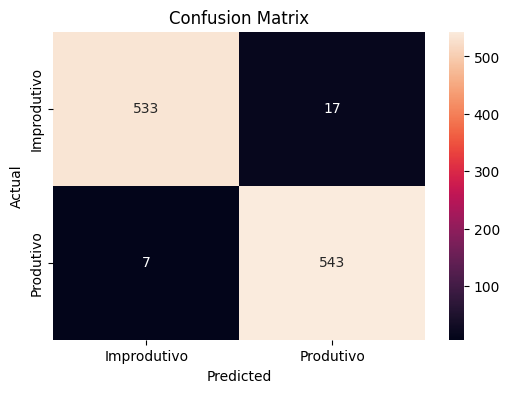

In [ ]:
def evaluate_model(model, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    print(f'Final Validation Loss: {avg_val_loss:.4f}')
    print(f'Final Validation Accuracy: {accuracy * 100:.2f}%\n')
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Improdutivo', 'Produtivo']))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Improdutivo', 'Produtivo'], yticklabels=['Improdutivo', 'Produtivo'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, val_loader)

In [ ]:
def predict_email(text, model, tokenizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1)

    return 'Produtivo' if prediction.item() == 1 else 'Improdutivo'

In [ ]:
test_email = '''
Olá,

Surgiu um problema durante a tarefa e precisamos resolver com urgência. Agende uma reunião amanhã com o cliente.

Atenciosamente,
Mario.
'''

test_email = re.sub(r'[*#_\->|]', '', test_email)
test_email = ' '.join(test_email.split())

print(test_email)

prediction = predict_email(test_email, model, tokenizer)
print(f'Predição: {prediction}')

Olá, Surgiu um problema durante a tarefa e precisamos resolver com urgência. Agende uma reunião amanhã com o cliente. Atenciosamente, Mario.
Predição: Produtivo


# Salvar e Exportar

In [ ]:
model.save_pretrained('distilbert-email-productivity-classifier-pt')
tokenizer.save_pretrained('distilbert-email-productivity-classifier-pt')

('distilbert-email-productivity-classifier-pt/tokenizer_config.json',
 'distilbert-email-productivity-classifier-pt/special_tokens_map.json',
 'distilbert-email-productivity-classifier-pt/vocab.txt',
 'distilbert-email-productivity-classifier-pt/added_tokens.json',
 'distilbert-email-productivity-classifier-pt/tokenizer.json')

In [ ]:
from huggingface_hub import login
login()

In [ ]:
model.push_to_hub("hadson0/distilbert-email-productivity-classifier-pt")
tokenizer.push_to_hub("hadson0/distilbert-email-productivity-classifier-pt")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/hadson0/distilbert-email-productivity-classifier-pt/commit/e4291920bdba25347153c2d0e0fb0a591e81ab00', commit_message='Upload tokenizer', commit_description='', oid='e4291920bdba25347153c2d0e0fb0a591e81ab00', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hadson0/distilbert-email-productivity-classifier-pt', endpoint='https://huggingface.co', repo_type='model', repo_id='hadson0/distilbert-email-productivity-classifier-pt'), pr_revision=None, pr_num=None)